Importar librerías

In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

Leo todos los csv que se generaron de los registros

In [2]:
segment_dict = {'Offline': 0, 'Online': 1, 'Groups': 2, 'Complementary': 3, 'Direct': 4, 'Corporate': 5, 'Undefined': 6, 'Aviation': 7, 'Full': 8}
segment_list = ['Offline', 'Online', 'Groups', 'Complementary', 'Direct', 'Corporate', 'Undefined', 'Aviation', 'Full']

Offline = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[0] + '.csv')
Online = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[1] + '.csv')
Groups = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[2] + '.csv')
Complementary = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[3] + '.csv')
Direct = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[4] + '.csv')
Corporate = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[5] + '.csv')
Undefined = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[6] + '.csv')
Aviation = pd.read_csv('C:/Users/Usuario/Documents/Jupyter/Proyecto/' + segment_list[7] + '.csv')

Full = Offline.copy()

TS = [Offline, Online, Groups, Complementary, Direct, Corporate, Undefined, Aviation, Full]

for k in range(1, len(segment_list) - 1):
    TS[8].iloc[:, 1:] = TS[8].iloc[:, 1:] + TS[k].iloc[:, 1:].copy()


Definimmos dos funciones para graficar:

In [33]:
def plot_series(df, name):
    df = df.transpose().reset_index().copy()
    df.columns = df.iloc[0]
    df = df.iloc[1:, :]
    df = df.rename(columns={'date': 'lead'})
    df = df.reset_index(drop = True)
    figure = sns.lineplot(data = df, linestyle = 'solid', dashes = False,  legend = False)
    figure.set(xlabel = 'Lead',
               ylabel = 'Reservations',
               title = name)
    return figure

In [124]:
def subplot_series(df, name, ax, i):
    df = df.transpose().reset_index().copy()
    df.columns = df.iloc[0]
    df = df.iloc[1:, :]
    df = df.rename(columns={'date': 'lead'})
    df = df.reset_index(drop = True)
    
    figure = sns.lineplot(data = df, linestyle = 'solid', dashes = False,  legend = False, ax = ax)#[i])
    figure.set(xlabel = 'Lead',
               ylabel = 'Reservations',
               title = name)
    return figure

Grafico la TS principal y también la grafico por componentes:

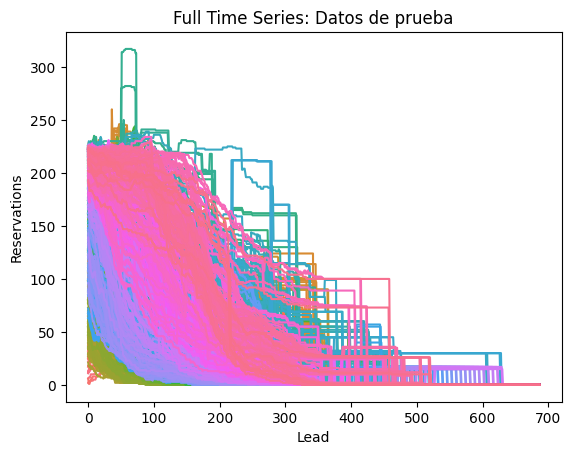

In [5]:
plot_series(TS[8], segment_list[8] + ' Time Series: Datos de prueba')

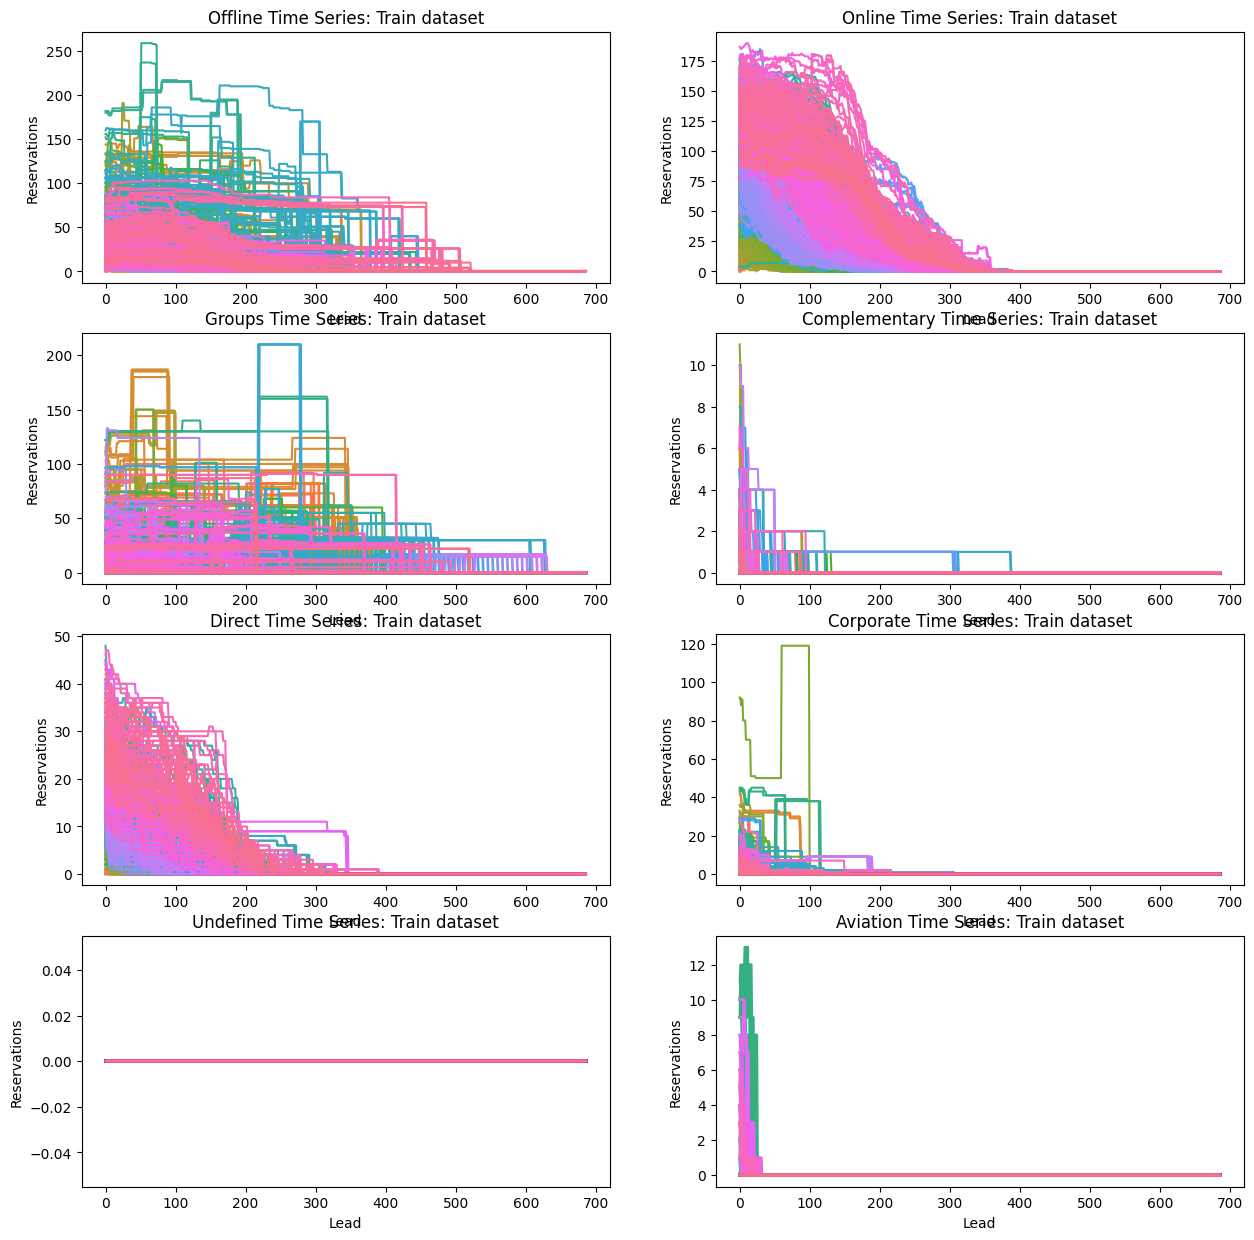

In [6]:
figure, ax =plt.subplots(4, 2, figsize = (15, 15))
ax = ax.flatten()

for k in range(0, len(segment_list) - 1):
    subplot_series(TS[k], segment_list[k] + ' Time Series: Train dataset', ax, k)
    figure.tight_layout()

Revisamos la longitud máxima de las series de tiempo en cada uno de los dataframes, para ver si coinciden con las longitudes de las gráficas y reducir las longitudes de modo que se eliminen las columnas que no aportan información

In [7]:

max_list = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for k in range(0, len(segment_list)):
    size = 0
    for j in range(TS[k].shape[1] - 1, 0, -1):
        if TS[k].iloc[:, j].sum() == 0:
            size = size + 1
        else:
            j = 0
            
    max_list[k] = TS[k].shape[1] - 1 - size

    #cambiar formato de fecha
    TS[k]['date'] = pd.to_datetime(TS[k]['date'])

    #imprimir longitudes máximas de las TS
    print(segment_list[k], 'Time Series max size:', max_list[k])


Offline Time Series max size: 522
Online Time Series max size: 391
Groups Time Series max size: 631
Complementary Time Series max size: 388
Direct Time Series max size: 391
Corporate Time Series max size: 307
Undefined Time Series max size: 0
Aviation Time Series max size: 32
Full Time Series max size: 631


De lo anterior podemos ver que las dimensiones coinciden, por lo que de las TS descompuestas, podemos ver que los segmentos *direct* y *online* son los que tienen un comportamiento esperable, mientras que *groups* y *offline* tienen un comportamiento mucho más caótico o espontáneo. Del resto de descomposiciones podemos decir que son despreciables, ya que los máximos son muy pequeños(*aviation* y *complementary*), o bien agregan una gran cantidad de reservas para luego cancelarlas (*corporate*). Aunque la apuesta es tratar las TS a través de descomposiciones, también haremos un pronóstico con las TS sin descomponer.

Continuando con las TS, eliminamos las colummnas que están llenas de ceros:

In [8]:
MaxDim = TS[0].shape
for i in range(0, len(segment_list)):
    for j in range(MaxDim[1] - 2, max_list[i] + 1 , -1):
        TS[i] = TS[i].drop([str(j)], axis=1)



Imprimimos las nuevas dimensiones de cada dataset y calculo el conjunto de entrenamiento

In [9]:
print('DataFrames dimension [ rows=TimeSeries x columns=LeadDays ]:\n')
for i in range(0, len(segment_list)):
    print('[', TS[i].shape[0], 'x', TS[i].shape[1], ']\t(', segment_list[i], 'size)')

print('Para dividir el conjunto en 80% entrenamiento y 20% prueba, el conjunto de prueba debe tener aproximadamente:', math.floor(TS[i].shape[0] * .2 / 30), 'meses')

DataFrames dimension [ rows=TimeSeries x columns=LeadDays ]:

[ 793 x 525 ]	( Offline size)
[ 793 x 394 ]	( Online size)
[ 793 x 634 ]	( Groups size)
[ 793 x 391 ]	( Complementary size)
[ 793 x 394 ]	( Direct size)
[ 793 x 310 ]	( Corporate size)
[ 793 x 3 ]	( Undefined size)
[ 793 x 35 ]	( Aviation size)
[ 793 x 634 ]	( Full size)
Para dividir el conjunto en 80% entrenamiento y 20% prueba, el conjunto de prueba debe tener aproximadamente: 5 meses


Pero son muy pocos datos, así que solo sacaré a agosto para hacer el conjunto de prueba y de una vez voy a crear al conjunto de validación:

In [22]:
TS_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]
TS_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

Result = TS[len(segment_list) - 1].iloc[TS[len(segment_list) - 1].shape[0] - 31:TS[len(segment_list) - 1].shape[0], :].copy().reset_index(drop = True)

for k in range(0, len(segment_list)):
    TS_train[k] = TS[k].iloc[0:TS[k].shape[0] - 31, :].copy()
    
    TS_test[k] = TS[k].iloc[TS[k].shape[0] - 31:TS[k].shape[0], :].copy().reset_index(drop = True)
    for i in range(0, TS_test[k].shape[0]):
        TS_test[k].iloc[i, 1:2 + i] = 0

TS_test[0].shape[0]


31

Creamos la función para el pickup

In [11]:
def pickup(book, date_today, date_forecast):
    lead = (date_forecast - date_today).days

    minDate = book['date'].min()
    rowForecast = (date_forecast - minDate).days
    rowPickup = ((date_forecast - relativedelta(years=1)) - minDate).days
    maxLead = book.shape[1] - 2

    occ = [0] * (maxLead + 1)
    variation = [0] * (maxLead + 1)
    if lead <= maxLead:
        variation[lead:] = book.iloc[rowForecast, lead + 1:] - book.iloc[rowPickup, lead + 1:].copy()
        
    occ = book.iloc[rowPickup, 1:] + variation

    return occ
            

Escalamos los conjuntos de entrenamiento para cada uno de los modelos

In [12]:
X = [0, 0, 0, 0, 0, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 0, 0, 0, 0]
scaler_X = [0, 0, 0, 0, 0, 0, 0, 0, 0]
scaler_y = [0, 0, 0, 0, 0, 0, 0, 0, 0]
X_scaled = [0, 0, 0, 0, 0, 0, 0, 0, 0]
y_scaled = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for k in range(0, len(segment_list)):
    X[k] = np.array(TS_train[k].iloc[:, 2:])
    y[k] = np.array(TS_train[k].iloc[:, 1])
    
    # Escalar las características y las etiquetas
    scaler_X[k] = StandardScaler()
    scaler_y[k] = StandardScaler()
    
    X_scaled[k] = scaler_X[k].fit_transform(X[k])
    y_scaled[k] = scaler_y[k].fit_transform(y[k].reshape(-1, 1)).ravel()


creamos 24 modelos SVR: 8 lineales, 8 Radial Base y 8 con Sigmoide.

In [13]:

# Entrenar el modelo SVR Linear
model_Linear = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for k in range(0, len(segment_list)):
    model_Linear[k] = SVR(kernel='linear', C=5, epsilon=0.4)
    model_Linear[k].fit(X_scaled[k], y_scaled[k])

def svr_Linear(book, date_today, date_forecast, k):
    
    lead = (date_forecast - date_today).days
    maxLead = book.shape[1] - 2
    minDate = book['date'].min()
    occ = [0] * maxLead
    
    rowForecast = (date_forecast - minDate).days
    occ[0:maxLead - lead + 1] = book.iloc[rowForecast, lead + 1:].copy()  # Usar la primera serie como nueva
        
    for i in range(0, lead):
        # Escalar la ventana actual
        known_scaled = scaler_X[k].transform(np.array(occ).reshape(1, -1))
        
        # Predecir el siguiente valor
        prediction_scaled = model_Linear[k].predict(known_scaled)
        prediction = 0
        prediction = scaler_y[k].inverse_transform(prediction_scaled.reshape(-1, 1)).ravel()[0]
            
        # Agregar predicción a la lista
        if i < lead - 1:
            occ[1:] = occ[:-1]
            occ[0] = prediction
        
    return pd.Series([prediction] + occ)
    

In [14]:

# Entrenar el modelo SVR RBF
model_RBF = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for k in range(0, len(segment_list)):
    model_RBF[k] = SVR(kernel='rbf', C=5, epsilon=0.2)
    model_RBF[k].fit(X_scaled[k], y_scaled[k])


def svr_RBF(book, date_today, date_forecast, k):
    
    lead = (date_forecast - date_today).days
    maxLead = book.shape[1] - 2
    minDate = book['date'].min()
    occ = [0] * maxLead
    
    rowForecast = (date_forecast - minDate).days
    occ[0:maxLead - lead + 1] = book.iloc[rowForecast, lead + 1:].copy()  # Usar la primera serie como nueva
        
    for i in range(0, lead):
        # Escalar la ventana actual
        known_scaled = scaler_X[k].transform(np.array(occ).reshape(1, -1))
        
        # Predecir el siguiente valor
        prediction_scaled = model_RBF[k].predict(known_scaled)
        prediction = 0
        prediction = scaler_y[k].inverse_transform(prediction_scaled.reshape(-1, 1)).ravel()[0]
            
        # Agregar predicción a la lista
        if i < lead - 1:
            occ[1:] = occ[:-1]
            occ[0] = prediction
        
    return pd.Series([prediction] + occ)
    

In [15]:

# Entrenar el modelo SVR Sigmoid
model_Sigmoid = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for k in range(0, len(segment_list)):
    model_Sigmoid[k] = SVR(kernel='sigmoid', C=15, epsilon=0.2)
    model_Sigmoid[k].fit(X_scaled[k], y_scaled[k])


def svr_Sigmoid(book, date_today, date_forecast, k):
    
    lead = (date_forecast - date_today).days
    maxLead = book.shape[1] - 2
    minDate = book['date'].min()
    occ = [0] * maxLead
    
    rowForecast = (date_forecast - minDate).days
    occ[0:maxLead - lead + 1] = book.iloc[rowForecast, lead + 1:].copy()  # Usar la primera serie como nueva
        
    for i in range(0, lead):
        # Escalar la ventana actual
        known_scaled = scaler_X[k].transform(np.array(occ).reshape(1, -1))
        
        # Predecir el siguiente valor
        prediction_scaled = model_Sigmoid[k].predict(known_scaled)
        prediction = 0
        prediction = scaler_y[k].inverse_transform(prediction_scaled.reshape(-1, 1)).ravel()[0]
            
        # Agregar predicción a la lista
        if i < lead - 1:
            occ[1:] = occ[:-1]
            occ[0] = prediction
        
    return pd.Series([prediction] + occ)
    

Creamos los pronósticos

In [16]:
reference_day = datetime.datetime.strptime('2017-07-31', '%Y-%m-%d')

TS_Pickup = [0, 0, 0, 0, 0, 0, 0, 0, 0]
TS_SVR_Linear = [0, 0, 0, 0, 0, 0, 0, 0, 0]
TS_SVR_RBF = [0, 0, 0, 0, 0, 0, 0, 0, 0]
TS_SVR_Sigmoid = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for k in range(0, len(segment_list)):
    TS_Pickup[k] = TS_test[k].copy()
    TS_Pickup[k].iloc[:, 1:] = 0
    
    TS_SVR_Linear[k] = TS_test[k].copy()
    TS_SVR_Linear[k].iloc[:, 1:] = 0

    TS_SVR_RBF[k] = TS_test[k].copy()
    TS_SVR_RBF[k].iloc[:, 1:] = 0
    
    TS_SVR_Sigmoid[k] = TS_test[k].copy()
    TS_SVR_Sigmoid[k].iloc[:, 1:] = 0

    for i in range(0, TS_test[k].shape[0]):
        TS_Pickup[k].iloc[i, 1:] = pickup(TS[k], reference_day, reference_day +  datetime.timedelta(days = i + 1))
        TS_SVR_Linear[k].iloc[i, 1:] = svr_Linear(TS_test[k], reference_day, reference_day +  datetime.timedelta(days = i + 1), k)
        TS_SVR_RBF[k].iloc[i, 1:] = svr_RBF(TS_test[k], reference_day, reference_day +  datetime.timedelta(days = i + 1), k)
        TS_SVR_Sigmoid[k].iloc[i, 1:] = svr_Sigmoid(TS_test[k], reference_day, reference_day +  datetime.timedelta(days = i + 1), k)
    

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5220\1903882381.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.1322287697744' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  TS_SVR_Linear[k].iloc[i, 1:] = svr_Linear(TS_test[k], reference_day, reference_day +  datetime.timedelta(days = i + 1), k)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5220\1903882381.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.8058294582608' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  TS_SVR_RBF[k].iloc[i, 1:] = svr_RBF(TS_test[k], reference_day, reference_day +  datetime.timedelta(days = i + 1), k)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5220\1903882381.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise

Reconstrucción de las series de tiempo

In [18]:
Max = 0
Max_index = 0
for k in range(0, len(segment_list) - 1):
    if TS[k].shape[1] > Max:
        Max = TS[k].shape[1]
        Max_index = k

Result_list = ['Pick-Up', 'SVR Linear', 'SVR RBF', 'SVR Sigmoid']
Result_dict = {'Pick-Up': 1, 'SVR Linear': 2, 'SVR RBF': 3, 'SVR Sigmoid': 4}
Res_Comp = [0, 0, 0, 0]
Res_Full = [0, 0, 0, 0]

Res_Comp[0] = TS_Pickup[Max_index].copy()
Res_Comp[1] = TS_SVR_Linear[Max_index].copy()
Res_Comp[2] = TS_SVR_RBF[Max_index].copy()
Res_Comp[3] = TS_SVR_Sigmoid[Max_index].copy()

Res_Full[0] = TS_Pickup[len(segment_list) - 1].copy()
Res_Full[1] = TS_SVR_Linear[len(segment_list) - 1].copy()
Res_Full[2] = TS_SVR_RBF[len(segment_list) - 1].copy()
Res_Full[3] = TS_SVR_Sigmoid[len(segment_list) - 1].copy()

for k in range(0, len(segment_list) - 1):
    if k != Max_index:
        m = TS_train[k].shape[1]
        Res_Comp[0].iloc[:, 1:m] = Res_Comp[0].iloc[:, 1:m] + TS_Pickup[k].iloc[:, 1:m].copy()
        Res_Comp[1].iloc[:, 1:m] = Res_Comp[1].iloc[:, 1:m] + TS_SVR_Linear[k].iloc[:, 1:m].copy()
        Res_Comp[2].iloc[:, 1:m] = Res_Comp[2].iloc[:, 1:m] + TS_SVR_RBF[k].iloc[:, 1:m].copy()
        Res_Comp[3].iloc[:, 1:m] = Res_Comp[3].iloc[:, 1:m] + TS_SVR_Sigmoid[k].iloc[:, 1:m].copy()


Graficamos todos los resultados:

[(160.0, 230.0)]

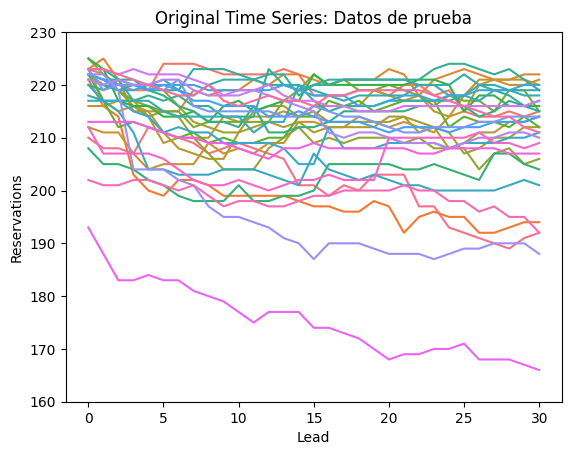

In [41]:
figure = plot_series(Result.iloc[:, :32],'Original Time Series: Datos de prueba')
figure.set(ylim = (160, 230))
plt.savefig("2")

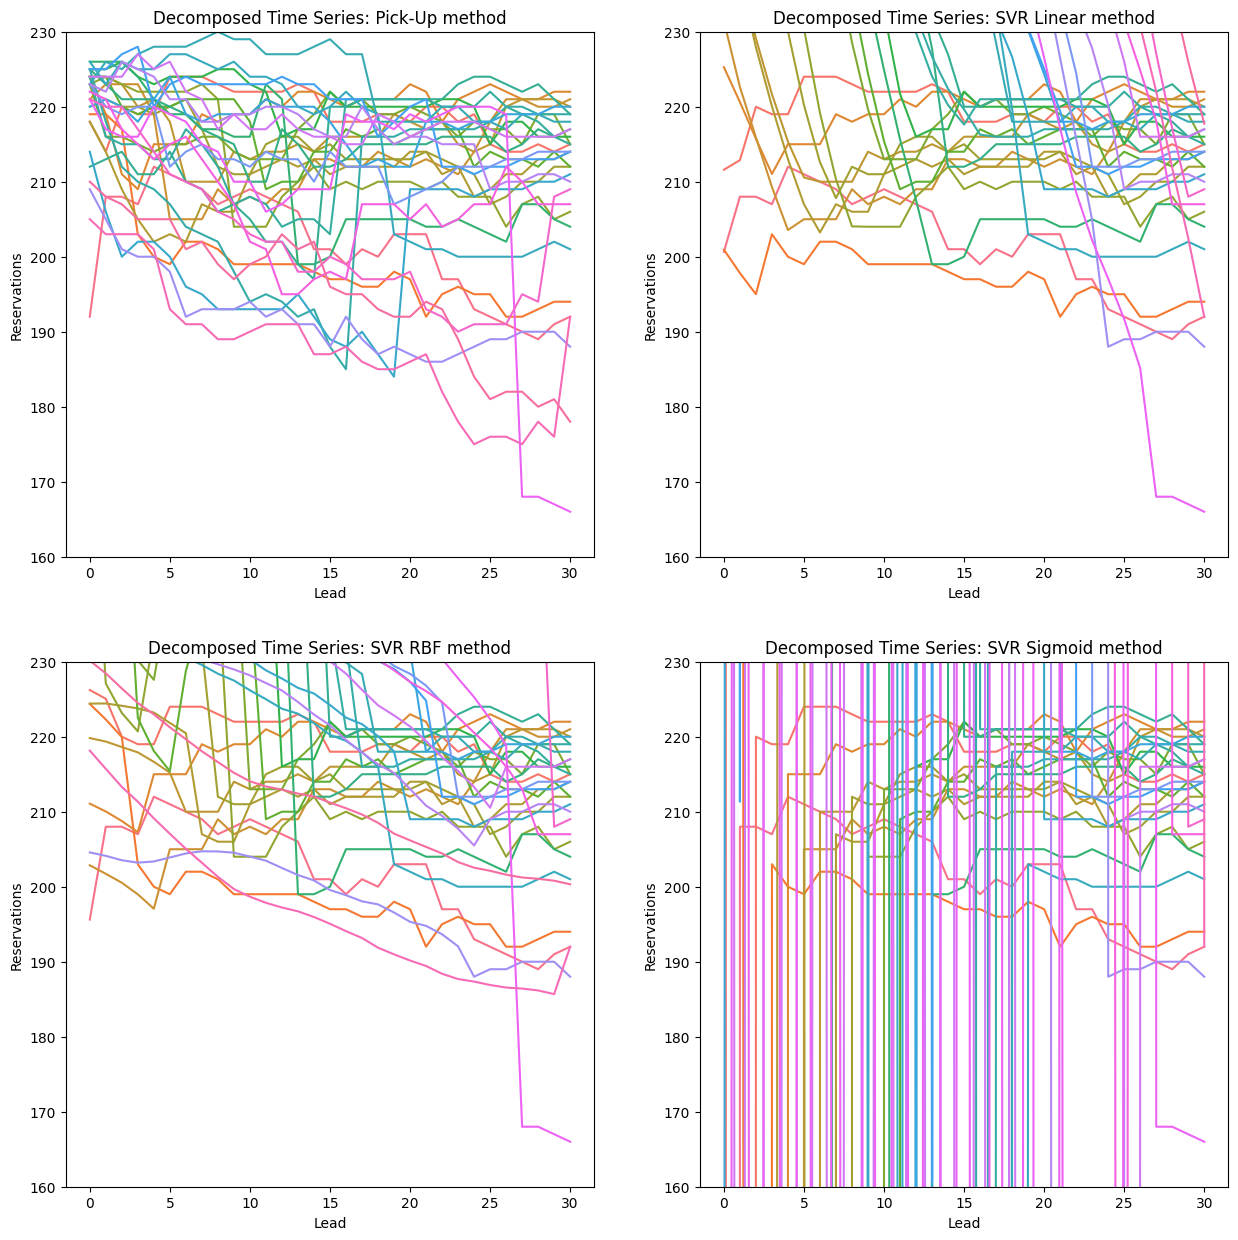

In [40]:
figure, ax = plt.subplots(2, 2, figsize = (15, 15))
ax = ax.flatten()

for k in range(0, len(Res_Comp)):
    figure = subplot_series(Res_Comp[k].iloc[:, :32], 'Decomposed Time Series: ' + Result_list[k] + ' method', ax, k)
    figure.set(ylim = (160, 230))

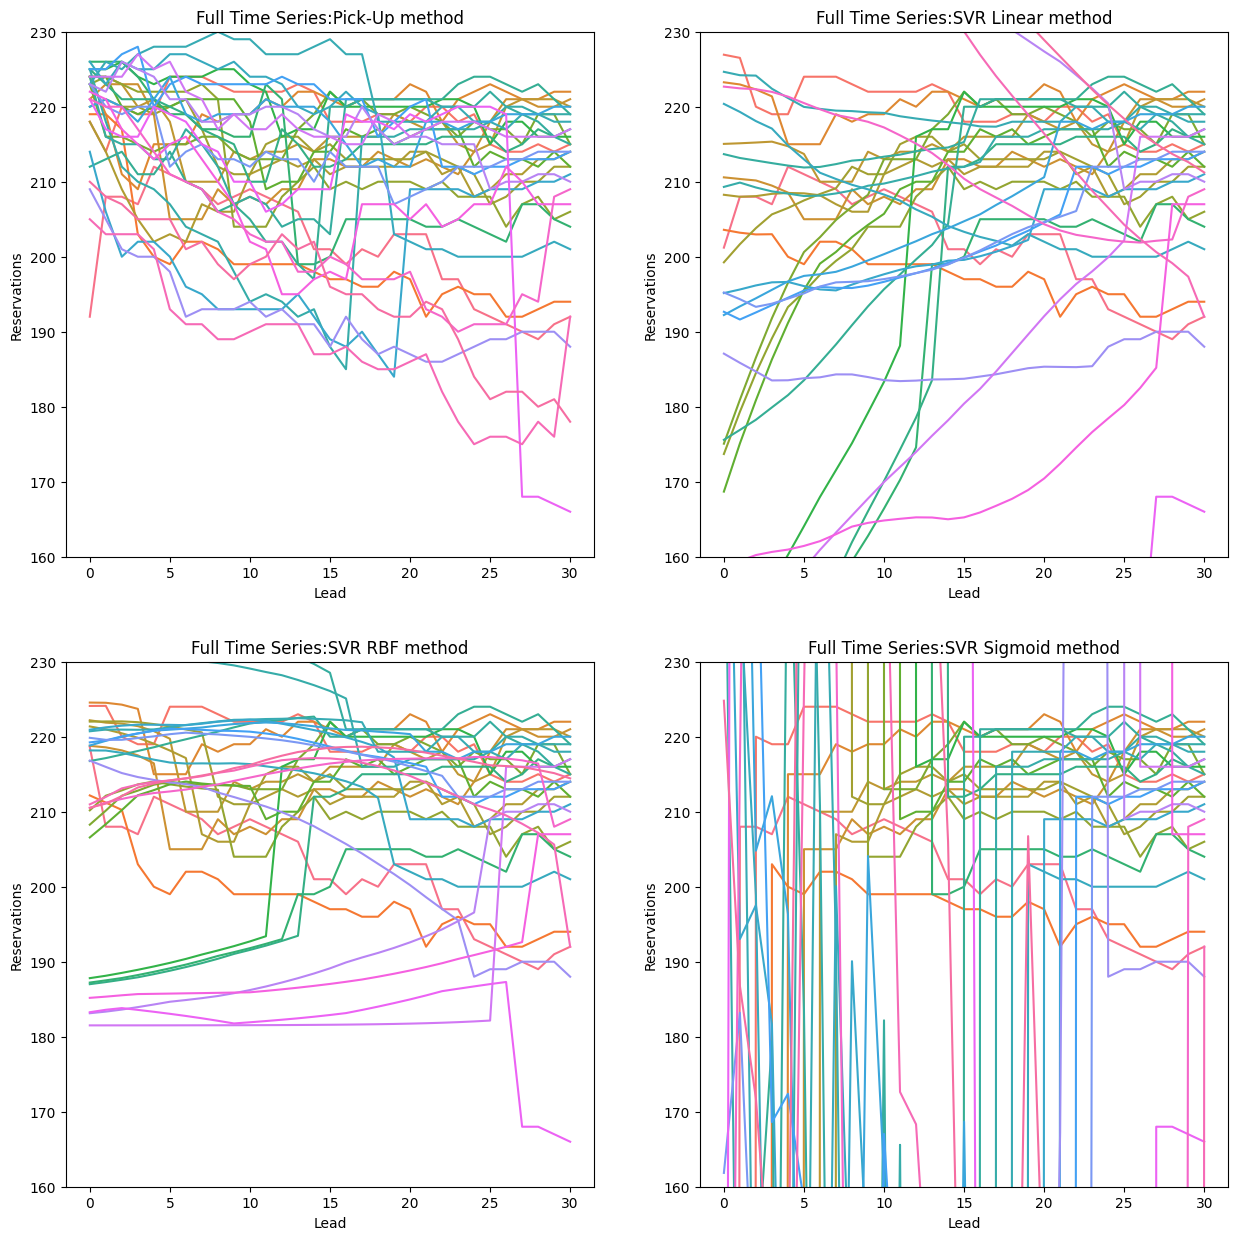

In [39]:
figure, ax =plt.subplots(2, 2, figsize = (15, 15))
ax = ax.flatten()

for k in range(0, len(Res_Full)):
    figure = subplot_series(Res_Full[k].iloc[:, :32], 'Full Time Series:' + Result_list[k] + ' method', ax, k)
    figure.set(ylim = (160, 230))

Sigue evaluar los modelos. Podría usar DTW, pero las series de tiempo no sufren deformaciones de forma horizontal: cada entrada de las series pronosticadas nos dice la cantidad de reservaciones que hay en un día en específico respecto a una fecha de llegada, y lo que me interesa saber es qué tan preciso fue el modelo para cada uno de estos días, por lo que me interesa saber la variación de cada entrada respecto al eje Y, así que puedo utilizar una métrica con un fundamento más sencillo.

Otro punto a considerar es que, la TS de mañana solo pronostica un día, la de pasado mañana pronostica dos días, y así de forma consecutiva durante 31 días, así que estoy pronosticando la cantidad de reservaciones en *31 x 32 / 2 = 496* entradas. Si bien es cierto que la variación se hará más notoria mientras vayan incrementando los días de anticipación con los que se hace el pronóstico, yo esperaría obtener una serie de tiempo bien ajustada, así que la métrica a utilizar es la siguiente:

In [76]:
from sklearn.metrics import mean_squared_error 

def eval_mse(Result, Predict):
    Y_result = []
    Y_predict = []
    
    for i in range(0, Result.shape[0]):
        result = []
        predict = []
        result = Result.iloc[i, 1:2 + i].values.tolist()
        predict = Predict.iloc[i, 1:2 + i].values.tolist()

        for i in range(0, len(result)):
            result[i] = float(result[i])
            predict[i] = float(predict[i])
        
        Y_result = Y_result + result
        Y_predict = Y_predict + predict
    
    return float(mean_squared_error(Y_result,Y_predict))



In [90]:
print('Mean Squared Error en TS Principal:')
for i in range (0, len(Res_Full)):
    print(Result_list[i], ': ', eval_mse(Result, Res_Full[i]))

print('\nMean Squared Error en TS por Descomposición:')
for i in range (0, len(Res_Comp)):
    print(Result_list[i], ': ', eval_mse(Result, Res_Comp[i]))

Mean Squared Error en TS Principal:
Pick-Up :  218.77217741935485
SVR Linear :  995.0995777098211
SVR RBF :  244.88335668475983
SVR Sigmoid :  112955345.97577679

Mean Squared Error en TS por Descomposición:
Pick-Up :  218.77217741935485
SVR Linear :  22635.129905119462
SVR RBF :  1139.3830141353485
SVR Sigmoid :  361351948.81885016


# Gráficas de apoyo para el reporte:

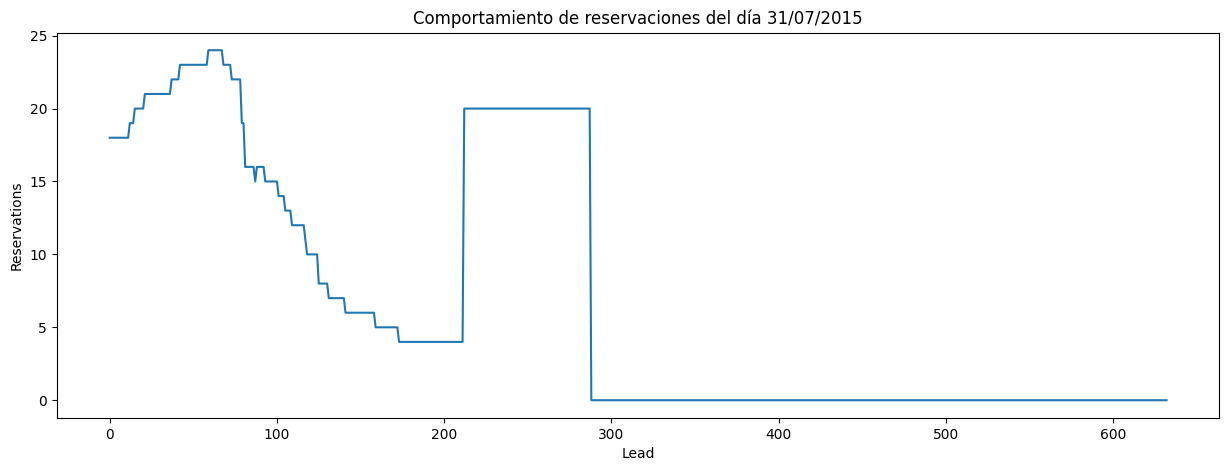

In [126]:
figure, ax =plt.subplots(1, 1, figsize = (15, 5))
#ax = ax.flatten()

subplot_series(TS[8].iloc[30, :], 'Comportamiento de reservaciones del día 31/07/2015', ax, 0)
plt.savefig("2")

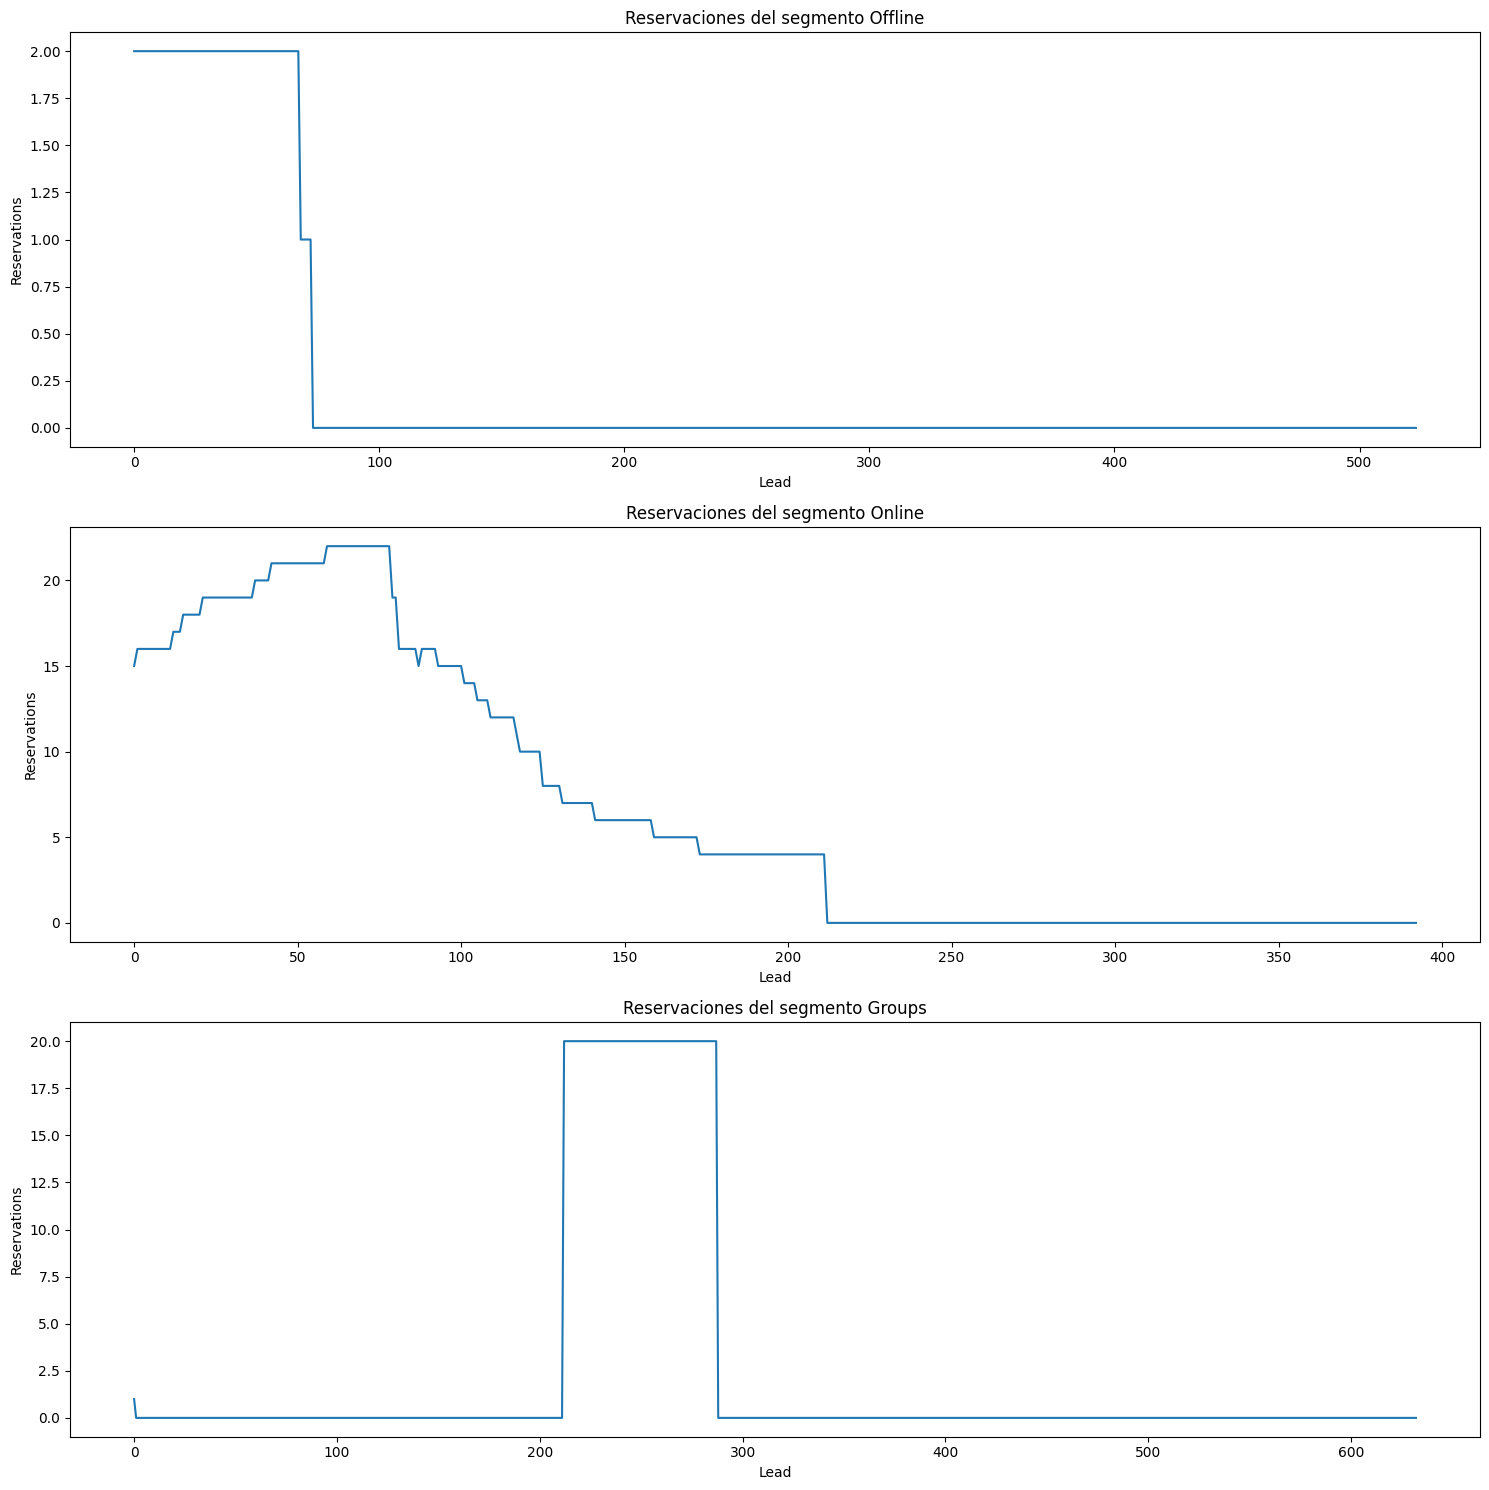

In [119]:
figure, ax =plt.subplots(3, 1, figsize = (15, 15))
ax = ax.flatten()

for k in range(0, 3):
    subplot_series(TS[k].iloc[30, :], 'Reservaciones del segmento ' + segment_list[k], ax, k)
    figure.tight_layout()
    plt.savefig("1")

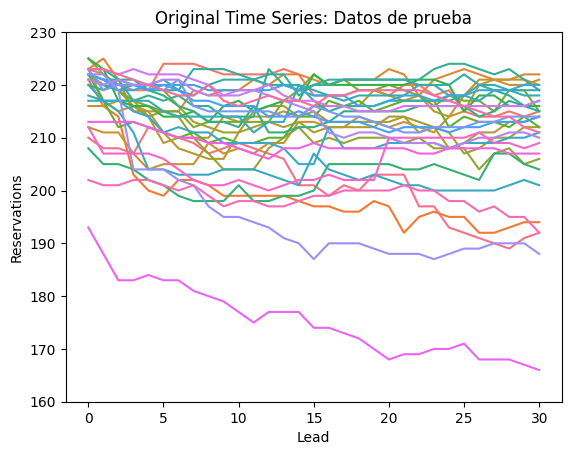

In [127]:
figure = plot_series(Result.iloc[:, :32],'Original Time Series: Datos de prueba')
figure.set(ylim = (160, 230))
plt.savefig("3")

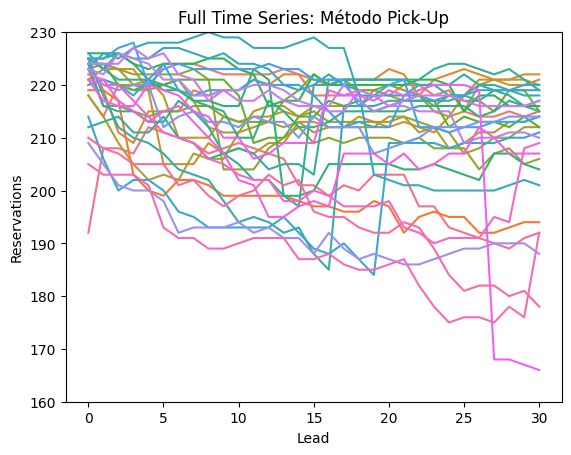

In [128]:
figure = plot_series(Res_Full[0].iloc[:, :32],'Full Time Series: Método Pick-Up')
figure.set(ylim = (160, 230))
plt.savefig("4")

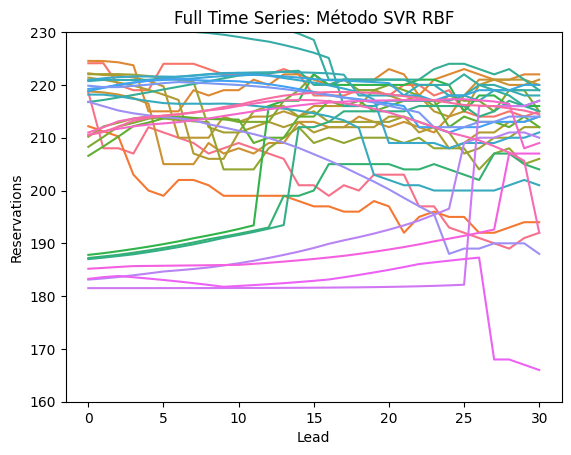

In [129]:
figure = plot_series(Res_Full[2].iloc[:, :32],'Full Time Series: Método SVR RBF')
figure.set(ylim = (160, 230))
plt.savefig("5")